In [476]:
import folium
import json
import pandas as pd
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

In [477]:
with open('data/stanice.json') as file:
    stanice = json.load(file)

In [478]:
meteo_stanice = []
i = 1
for stanica in stanice:
    print(i, stanica['id'], stanica['name'])
    i += 1
    id = stanica['id']
    start = stanica['start']
    end = stanica['end']
    meteo = f"data/Stanica {id}/GDAS_{start}_{end}_{id}.csv"
    polutanti = f"data/Stanica {id}/Polutanti_{start}_{end}_{id}.csv"    
    
    g_data = pd.read_csv(meteo)
    g_data = g_data.dropna()
    g_data['Date']= pd.to_datetime(g_data['Date'])
    g_data.t02m -= 273.15  # convert to Celsius
    
    p_data = pd.read_csv(polutanti)
    p_data = p_data.dropna()
    p_data['Date']= pd.to_datetime(p_data['Date'])
    
    meteo_stanice.append([g_data, p_data])
    

1 IPH Institut za javno zdravlje Beograd
2 NBG Novi Beograd
3 OBR Obrenovac
4 LAZ Lazaravac
5 OVC Ovča
6 USC Mesna zajednica Ušće
7 ZEM Zemun – Tošin bunar
8 VEL Veliki Crljeni


In [479]:
spojeni_podaci_stanice_2018 = []
i = 0
for stanica in meteo_stanice:
    data_meteo = stanica[0]
    data_polutanti = stanica[1]
    data_meteo_2018 = data_meteo[(data_meteo.Date > '2017-12-31 23:59:59') & (data_meteo.Date < '2018-12-31 23:59:59')]
    data_polutanti_2018 = data_polutanti[(data_polutanti.Date > '2017-12-31 23:59:59') & (data_polutanti.Date < '2018-12-31 23:59:59')]
    
    data_2018_meteo_1h = data_meteo_2018.resample('H', on="Date").mean()
    data_2018_meteo_1h = data_2018_meteo_1h.interpolate(method='polynomial', order=1)

    m_data = pd.merge(data_2018_meteo_1h, data_polutanti_2018, left_on='Date', right_on='Date')
    try:
        print(i, stanice[i]['id'], m_data.PM10[0])
        spojeni_podaci_stanice_2018.append([i, m_data])
    except:
        print(i, stanice[i]['id'], '---')
    i += 1

# i = 0
# for el in spojeni_podaci_stanice_2018:
#     print(i, el.PM10[0])
#     i += 1

0 IPH 146.55
1 NBG 224.17
2 OBR ---
3 LAZ ---
4 OVC 184.53
5 USC 81.59
6 ZEM ---
7 VEL 69.14


In [480]:
def fuzzy_interval(val, a, b, c, d):
    if val<a: 
        return 0
    elif val<b:
        return (val-a)/(b-a)
    elif val<c:
        return 1
    elif val<d:
        return (d-val)/(d-c)
    else:
        return 0

def kategorija(vrednost, tabela):
    for el in tabela:
        if vrednost>=el[0] and vrednost <=el[1]:
            return el[2]
    return -1
    
def status_vazduha(so2, no2, pm10):
    '''
    0 - odlican
    1 - dobar
    2 - prihvatljiv
    3 - zagadjen
    4 - jako zagadjen
    '''
    so2_tabela = [
        [0, 100, 0],
        [100.001, 200, 1],
        [200.001, 350, 2],
        [350.001, 500, 3],
        [500.001, 10000, 4]
    ]
    no2_tabela = [
        [0, 40, 0],
        [40.001, 100, 1],
        [100.001, 150, 2],
        [150.001, 400, 3],
        [400.001, 10000, 4]
    ]
#     pm10_tabela = [
#         [0, 20, 0],
#         [20.001, 40, 1],
#         [40.001, 50, 2],
#         [50.001, 100, 3],
#         [100.001, 10000, 4]
#     ]
    pm10_tabela = [
        [0, 50, 0],
        [50.001, 10000, 1]
    ]
    
    dobro = fuzzy_interval(pm10, -10, 0, 40, 50)
    lose = fuzzy_interval(pm10, 40, 50, 1000, 5000)

    
    r_so2 = kategorija(so2, so2_tabela)
    r_no2 = kategorija(no2, no2_tabela)
    r_pm10 = kategorija(pm10, pm10_tabela)
    ret = np.array([r_so2, r_no2, r_pm10, dobro, lose])
    # ret = np.array([so2, no2, pm10])
    return ret

def create_dataset(dataset, look_back=1, step = 8):
    dataX, dataY, dataT = [], [], []
#     input_features = [1, 11, 30, 31, 32, 33, 34]
    input_features = range(1, 35)
    for i in range(look_back, len(dataset), step):
        a = dataset.iloc[i-look_back:i, input_features]
        a = a.to_numpy()
        dataX.append(a)
        b = dataset.iloc[i]
        status = status_vazduha(b.SO2, b.NO2, b.PM10)
        dataT.append(dataset.iloc[i].Date)
        dataY.append([status[3], status[4]])
#         if status[4] == 1:
#             for ir in range(4):
#                 dataX.append(a)
#                 dataY.append([status[3], status[4]])
                
    return np.array(dataX), np.array(dataY), np.array(dataT)

In [481]:
m_data = spojeni_podaci_stanice_2018[1][1]
# m_data.describe().transpose()

In [482]:
look_back = 24
OUTPUT_FEATURE = 2

ds = create_dataset(m_data, look_back, 1)

x = ds[0]
y = ds[1]


n = y.shape[0]

train_rank = int(0.8*n)
test_rank = int(0.2*n)

train_subset = np.random.choice(x.shape[0], train_rank)
test_subset = np.random.choice(x.shape[0], test_rank)

X_train = x[train_subset]
# Y_train = y[train_subset][:, OUTPUT_FEATURE]
Y_train = y[train_subset]

# test dataset
X_test = x[test_subset]
# Y_test = y[test_subset][:, OUTPUT_FEATURE]
Y_test = y[test_subset]

feature_vector_length = X_train.shape[1]*X_train.shape[2]# 7*34

X_train = X_train.reshape((X_train.shape[0], feature_vector_length))
X_test = X_test.reshape((X_test.shape[0], feature_vector_length))


print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print('feature_vector_length', feature_vector_length)
print(y[:10])


(6715, 816)
(1678, 816)
(6715, 2)
feature_vector_length 816
[[0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [1.   0.  ]
 [1.   0.  ]
 [0.43 0.57]
 [0.   1.  ]
 [0.   1.  ]]


In [483]:
input_shape = (feature_vector_length,)
num_classes = 2
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(50, input_shape=input_shape, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(num_classes, activation='relu'))

model.build()
model.summary()

Feature shape: (816,)
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 50)                40850     
_________________________________________________________________
dropout_96 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_143 (Dense)            (None, 30)                1530      
_________________________________________________________________
dropout_97 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 2)                 62        
Total params: 42,442
Trainable params: 42,442
Non-trainable params: 0
_________________________________________________________________


In [484]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)


X_train = tf.keras.utils.normalize(X_train, axis=-1, order=1)
X_test = tf.keras.utils.normalize(X_test, axis=-1, order=1)


# Y_train = to_categorical(Y_train, num_classes=num_classes)
# Y_test = to_categorical(Y_test, num_classes=num_classes)
# print(Y_train[:100])


Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.float32)


In [485]:
from time import time
from tensorflow.keras.callbacks import TensorBoard

#     model.compile(
#         optimizer= tf.keras.optimizers.RMSprop(),  # Optimizer
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
#     )    

#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
metrics = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
]


# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=metrics)

# tensorboard = TensorBoard(log_dir='/home/djordje/logs/{}'.format(time()))

history = model.fit(X_train, Y_train, epochs=1000, batch_size=500, verbose=1, 
            validation_data=(X_test, Y_test), callbacks=[tensorboard])



Epoch 1/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.4457 - accuracy: 0.4633 - val_loss: 0.3524 - val_accuracy: 0.5781
Epoch 2/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.3224 - accuracy: 0.5266 - val_loss: 0.2452 - val_accuracy: 0.5417
Epoch 3/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.2381 - accuracy: 0.5394 - val_loss: 0.2288 - val_accuracy: 0.5417
Epoch 4/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.2317 - accuracy: 0.5569 - val_loss: 0.2261 - val_accuracy: 0.5417
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.2281 - accuracy: 0.5584 - val_loss: 0.2266 - val_accuracy: 0.5417
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.2276 - accuracy: 0.5596 - val_loss: 0.2258 - val_accuracy: 0.5417
Epoch 7/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.2272 - accuracy: 0.5573 - val_loss: 0.2256 - val_accuracy: 0.5417
Epoch 

14/14 [==============================] - 0s 3ms/step - loss: 0.1227 - accuracy: 0.8056 - val_loss: 0.1228 - val_accuracy: 0.7878
Epoch 116/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.8091 - val_loss: 0.1243 - val_accuracy: 0.7777
Epoch 117/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1173 - accuracy: 0.8133 - val_loss: 0.1219 - val_accuracy: 0.7867
Epoch 118/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1180 - accuracy: 0.8131 - val_loss: 0.1215 - val_accuracy: 0.7861
Epoch 119/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.8109 - val_loss: 0.1210 - val_accuracy: 0.7872
Epoch 120/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1169 - accuracy: 0.8134 - val_loss: 0.1205 - val_accuracy: 0.7878
Epoch 121/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1173 - accuracy: 0.8115 - val_loss: 0.1204 - val_accuracy: 0.7855
Epoch 1

Epoch 172/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0987 - accuracy: 0.8452 - val_loss: 0.1081 - val_accuracy: 0.8224
Epoch 173/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0997 - accuracy: 0.8412 - val_loss: 0.1075 - val_accuracy: 0.8099
Epoch 174/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0978 - accuracy: 0.8402 - val_loss: 0.1093 - val_accuracy: 0.8057
Epoch 175/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0987 - accuracy: 0.8434 - val_loss: 0.1082 - val_accuracy: 0.8075
Epoch 176/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0982 - accuracy: 0.8385 - val_loss: 0.1085 - val_accuracy: 0.8188
Epoch 177/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1029 - accuracy: 0.8380 - val_loss: 0.1107 - val_accuracy: 0.8117
Epoch 178/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1011 - accuracy: 0.8370 - val_loss: 0.1125 - val_accuracy:

Epoch 229/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0888 - accuracy: 0.8589 - val_loss: 0.1011 - val_accuracy: 0.8176
Epoch 230/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0891 - accuracy: 0.8573 - val_loss: 0.0991 - val_accuracy: 0.8278
Epoch 231/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0832 - accuracy: 0.8733 - val_loss: 0.1004 - val_accuracy: 0.8325
Epoch 232/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 0.8669 - val_loss: 0.1019 - val_accuracy: 0.8188
Epoch 233/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0841 - accuracy: 0.8636 - val_loss: 0.1011 - val_accuracy: 0.8188
Epoch 234/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0862 - accuracy: 0.8677 - val_loss: 0.0997 - val_accuracy: 0.8212
Epoch 235/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0898 - accuracy: 0.8568 - val_loss: 0.0991 - val_accuracy:

Epoch 286/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0789 - accuracy: 0.8730 - val_loss: 0.0943 - val_accuracy: 0.8361
Epoch 287/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0793 - accuracy: 0.8709 - val_loss: 0.0990 - val_accuracy: 0.8272
Epoch 288/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0803 - accuracy: 0.8721 - val_loss: 0.1017 - val_accuracy: 0.8212
Epoch 289/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0819 - accuracy: 0.8711 - val_loss: 0.0987 - val_accuracy: 0.8325
Epoch 290/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0817 - accuracy: 0.8666 - val_loss: 0.0942 - val_accuracy: 0.8397
Epoch 291/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0758 - accuracy: 0.8823 - val_loss: 0.0929 - val_accuracy: 0.8379
Epoch 292/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0770 - accuracy: 0.8711 - val_loss: 0.0931 - val_accuracy:

Epoch 343/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0726 - accuracy: 0.8774 - val_loss: 0.0894 - val_accuracy: 0.8451
Epoch 344/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0697 - accuracy: 0.8826 - val_loss: 0.0890 - val_accuracy: 0.8480
Epoch 345/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0689 - accuracy: 0.8859 - val_loss: 0.0894 - val_accuracy: 0.8456
Epoch 346/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.8866 - val_loss: 0.0900 - val_accuracy: 0.8516
Epoch 347/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0734 - accuracy: 0.8816 - val_loss: 0.0891 - val_accuracy: 0.8510
Epoch 348/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0735 - accuracy: 0.8824 - val_loss: 0.0892 - val_accuracy: 0.8504
Epoch 349/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0720 - accuracy: 0.8842 - val_loss: 0.0893 - val_accuracy:

Epoch 400/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0660 - accuracy: 0.8963 - val_loss: 0.0862 - val_accuracy: 0.8546
Epoch 401/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0668 - accuracy: 0.8963 - val_loss: 0.0871 - val_accuracy: 0.8540
Epoch 402/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0660 - accuracy: 0.8924 - val_loss: 0.0862 - val_accuracy: 0.8564
Epoch 403/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.8935 - val_loss: 0.0869 - val_accuracy: 0.8570
Epoch 404/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0658 - accuracy: 0.8963 - val_loss: 0.0863 - val_accuracy: 0.8570
Epoch 405/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0663 - accuracy: 0.8906 - val_loss: 0.0866 - val_accuracy: 0.8582
Epoch 406/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.8941 - val_loss: 0.0856 - val_accuracy:

Epoch 457/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0627 - accuracy: 0.8988 - val_loss: 0.0866 - val_accuracy: 0.8629
Epoch 458/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0602 - accuracy: 0.9063 - val_loss: 0.0834 - val_accuracy: 0.8653
Epoch 459/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0634 - accuracy: 0.8964 - val_loss: 0.0822 - val_accuracy: 0.8635
Epoch 460/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0597 - accuracy: 0.9002 - val_loss: 0.0836 - val_accuracy: 0.8594
Epoch 461/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9002 - val_loss: 0.0834 - val_accuracy: 0.8594
Epoch 462/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9042 - val_loss: 0.0826 - val_accuracy: 0.8647
Epoch 463/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0588 - accuracy: 0.9043 - val_loss: 0.0835 - val_accuracy:

Epoch 514/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0677 - accuracy: 0.8917 - val_loss: 0.0885 - val_accuracy: 0.8540
Epoch 515/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9021 - val_loss: 0.0820 - val_accuracy: 0.8647
Epoch 516/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 0.8971 - val_loss: 0.0814 - val_accuracy: 0.8671
Epoch 517/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9010 - val_loss: 0.0802 - val_accuracy: 0.8689
Epoch 518/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.9005 - val_loss: 0.0800 - val_accuracy: 0.8677
Epoch 519/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9091 - val_loss: 0.0798 - val_accuracy: 0.8665
Epoch 520/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0560 - accuracy: 0.9130 - val_loss: 0.0818 - val_accuracy:

Epoch 571/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0544 - accuracy: 0.9118 - val_loss: 0.0786 - val_accuracy: 0.8713
Epoch 572/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0519 - accuracy: 0.9157 - val_loss: 0.0821 - val_accuracy: 0.8713
Epoch 573/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0550 - accuracy: 0.9089 - val_loss: 0.0779 - val_accuracy: 0.8760
Epoch 574/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9125 - val_loss: 0.0787 - val_accuracy: 0.8737
Epoch 575/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 0.9152 - val_loss: 0.0778 - val_accuracy: 0.8778
Epoch 576/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0516 - accuracy: 0.9168 - val_loss: 0.0794 - val_accuracy: 0.8713
Epoch 577/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0543 - accuracy: 0.9145 - val_loss: 0.0777 - val_accuracy:

Epoch 628/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0520 - accuracy: 0.9146 - val_loss: 0.0823 - val_accuracy: 0.8665
Epoch 629/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0557 - accuracy: 0.9132 - val_loss: 0.0768 - val_accuracy: 0.8760
Epoch 630/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0509 - accuracy: 0.9139 - val_loss: 0.0781 - val_accuracy: 0.8731
Epoch 631/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0496 - accuracy: 0.9209 - val_loss: 0.0771 - val_accuracy: 0.8713
Epoch 632/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0501 - accuracy: 0.9183 - val_loss: 0.0774 - val_accuracy: 0.8749
Epoch 633/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0506 - accuracy: 0.9229 - val_loss: 0.0791 - val_accuracy: 0.8683
Epoch 634/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0513 - accuracy: 0.9227 - val_loss: 0.0782 - val_accuracy:

Epoch 685/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0482 - accuracy: 0.9224 - val_loss: 0.0748 - val_accuracy: 0.8796
Epoch 686/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9221 - val_loss: 0.0759 - val_accuracy: 0.8796
Epoch 687/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0479 - accuracy: 0.9213 - val_loss: 0.0748 - val_accuracy: 0.8784
Epoch 688/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0492 - accuracy: 0.9186 - val_loss: 0.0777 - val_accuracy: 0.8760
Epoch 689/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0461 - accuracy: 0.9275 - val_loss: 0.0762 - val_accuracy: 0.8772
Epoch 690/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9208 - val_loss: 0.0777 - val_accuracy: 0.8778
Epoch 691/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0517 - accuracy: 0.9167 - val_loss: 0.0772 - val_accuracy:

Epoch 742/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9290 - val_loss: 0.0749 - val_accuracy: 0.8802
Epoch 743/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0459 - accuracy: 0.9244 - val_loss: 0.0794 - val_accuracy: 0.8725
Epoch 744/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.9251 - val_loss: 0.0739 - val_accuracy: 0.8826
Epoch 745/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0449 - accuracy: 0.9253 - val_loss: 0.0745 - val_accuracy: 0.8790
Epoch 746/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0455 - accuracy: 0.9270 - val_loss: 0.0739 - val_accuracy: 0.8808
Epoch 747/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0476 - accuracy: 0.9252 - val_loss: 0.0760 - val_accuracy: 0.8802
Epoch 748/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0458 - accuracy: 0.9282 - val_loss: 0.0743 - val_accuracy:

Epoch 799/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.9221 - val_loss: 0.0733 - val_accuracy: 0.8796
Epoch 800/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 0.9274 - val_loss: 0.0725 - val_accuracy: 0.8802
Epoch 801/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0435 - accuracy: 0.9299 - val_loss: 0.0744 - val_accuracy: 0.8844
Epoch 802/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 0.9275 - val_loss: 0.0727 - val_accuracy: 0.8844
Epoch 803/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 0.9264 - val_loss: 0.0754 - val_accuracy: 0.8814
Epoch 804/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0440 - accuracy: 0.9282 - val_loss: 0.0721 - val_accuracy: 0.8796
Epoch 805/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0411 - accuracy: 0.9348 - val_loss: 0.0719 - val_accuracy:

Epoch 856/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0405 - accuracy: 0.9335 - val_loss: 0.0746 - val_accuracy: 0.8778
Epoch 857/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0421 - accuracy: 0.9278 - val_loss: 0.0716 - val_accuracy: 0.8844
Epoch 858/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9363 - val_loss: 0.0721 - val_accuracy: 0.8802
Epoch 859/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0441 - accuracy: 0.9268 - val_loss: 0.0718 - val_accuracy: 0.8814
Epoch 860/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0407 - accuracy: 0.9341 - val_loss: 0.0716 - val_accuracy: 0.8850
Epoch 861/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 0.9337 - val_loss: 0.0726 - val_accuracy: 0.8856
Epoch 862/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0438 - accuracy: 0.9262 - val_loss: 0.0766 - val_accuracy:

Epoch 913/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 0.9339 - val_loss: 0.0701 - val_accuracy: 0.8856
Epoch 914/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 0.9403 - val_loss: 0.0703 - val_accuracy: 0.8886
Epoch 915/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0395 - accuracy: 0.9385 - val_loss: 0.0701 - val_accuracy: 0.8874
Epoch 916/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0371 - accuracy: 0.9355 - val_loss: 0.0712 - val_accuracy: 0.8838
Epoch 917/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0406 - accuracy: 0.9347 - val_loss: 0.0711 - val_accuracy: 0.8880
Epoch 918/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9362 - val_loss: 0.0746 - val_accuracy: 0.8820
Epoch 919/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0408 - accuracy: 0.9352 - val_loss: 0.0718 - val_accuracy:

Epoch 970/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0382 - accuracy: 0.9346 - val_loss: 0.0699 - val_accuracy: 0.8874
Epoch 971/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0362 - accuracy: 0.9402 - val_loss: 0.0711 - val_accuracy: 0.8862
Epoch 972/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0404 - accuracy: 0.9342 - val_loss: 0.0714 - val_accuracy: 0.8850
Epoch 973/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0373 - accuracy: 0.9366 - val_loss: 0.0691 - val_accuracy: 0.8874
Epoch 974/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0381 - accuracy: 0.9337 - val_loss: 0.0701 - val_accuracy: 0.8892
Epoch 975/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0390 - accuracy: 0.9412 - val_loss: 0.0718 - val_accuracy: 0.8892
Epoch 976/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9407 - val_loss: 0.0704 - val_accuracy:

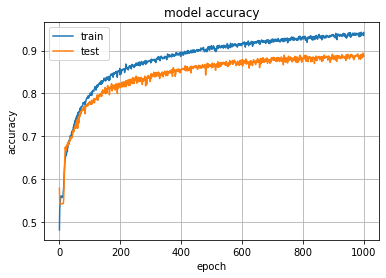

In [486]:
# summarize history for accuracy
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [487]:
# Test the model after training
test_results = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

53/53 [==============================] - 0s 420us/step - loss: 0.0699 - accuracy: 0.8886
Test results - Loss: 0.06985746324062347 - Accuracy: 0.8885577917098999%


In [488]:
pY = model.predict(X_test)
# plt.grid()
# plt.plot(np.argmax(Y_test, axis=1))
# plt.plot(np.argmax(pY, axis=1))
# plt.title('Predikcija')
# plt.show()

y_true = np.argmax(Y_test, axis=1)
y_pred = np.argmax(pY, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

aa = np.sum(np.all(Y_test == [1, 0], axis=1)) 
bb = np.sum(np.all(Y_test == [0, 1], axis=1)) 


print('Dobro: ', aa)
print('Lose: ', bb)
print('Ukupno sigurnih: ', aa+bb)
print(np.sum(cm))
# print(np.sum())
# print(np.sum())
print(Y_test.shape)
# print(Y_test)

[[807 102]
 [ 85 684]]
Dobro:  816
Lose:  658
Ukupno sigurnih:  1474
1678
(1678, 2)


In [496]:
# izdvojiti primere za koje je predikcija losa
err = np.abs(pY-Y_test)
indeksi = np.any(err>0.5, axis=1)
print(np.sum(indeksi))

XX_train = tf.concat([X_train, X_test[indeksi]], 0)
YY_train = tf.concat([Y_train, Y_test[indeksi]], 0)


157


In [497]:
history = model.fit(XX_train, YY_train, epochs=1000, batch_size=500, verbose=1, 
            validation_data=(X_test, Y_test), callbacks=[tensorboard])

Epoch 1/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0284 - accuracy: 0.9545 - val_loss: 0.0249 - val_accuracy: 0.9613
Epoch 2/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0274 - accuracy: 0.9561 - val_loss: 0.0277 - val_accuracy: 0.9511
Epoch 3/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0280 - accuracy: 0.9540 - val_loss: 0.0271 - val_accuracy: 0.9595
Epoch 4/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0295 - accuracy: 0.9527 - val_loss: 0.0268 - val_accuracy: 0.9571
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0279 - accuracy: 0.9550 - val_loss: 0.0276 - val_accuracy: 0.9553
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9550 - val_loss: 0.0262 - val_accuracy: 0.9619
Epoch 7/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0284 - accuracy: 0.9529 - val_loss: 0.0282 - val_accuracy: 0.9541
Epoch 

14/14 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9497 - val_loss: 0.0285 - val_accuracy: 0.9535
Epoch 116/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0280 - accuracy: 0.9549 - val_loss: 0.0275 - val_accuracy: 0.9553
Epoch 117/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9579 - val_loss: 0.0263 - val_accuracy: 0.9595
Epoch 118/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.9585 - val_loss: 0.0267 - val_accuracy: 0.9571
Epoch 119/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9562 - val_loss: 0.0272 - val_accuracy: 0.9577
Epoch 120/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9566 - val_loss: 0.0264 - val_accuracy: 0.9577
Epoch 121/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0272 - accuracy: 0.9553 - val_loss: 0.0264 - val_accuracy: 0.9595
Epoch 1

Epoch 172/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0278 - accuracy: 0.9547 - val_loss: 0.0284 - val_accuracy: 0.9523
Epoch 173/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0289 - accuracy: 0.9515 - val_loss: 0.0278 - val_accuracy: 0.9583
Epoch 174/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0297 - accuracy: 0.9495 - val_loss: 0.0275 - val_accuracy: 0.9535
Epoch 175/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0267 - accuracy: 0.9559 - val_loss: 0.0274 - val_accuracy: 0.9607
Epoch 176/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0287 - accuracy: 0.9536 - val_loss: 0.0376 - val_accuracy: 0.9356
Epoch 177/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0336 - accuracy: 0.9438 - val_loss: 0.0436 - val_accuracy: 0.9291
Epoch 178/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0371 - accuracy: 0.9370 - val_loss: 0.0395 - val_accuracy:

Epoch 229/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9569 - val_loss: 0.0268 - val_accuracy: 0.9547
Epoch 230/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9572 - val_loss: 0.0266 - val_accuracy: 0.9571
Epoch 231/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9574 - val_loss: 0.0261 - val_accuracy: 0.9595
Epoch 232/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0263 - accuracy: 0.9587 - val_loss: 0.0285 - val_accuracy: 0.9553
Epoch 233/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0273 - accuracy: 0.9555 - val_loss: 0.0259 - val_accuracy: 0.9553
Epoch 234/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0280 - accuracy: 0.9545 - val_loss: 0.0278 - val_accuracy: 0.9535
Epoch 235/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9553 - val_loss: 0.0271 - val_accuracy:

Epoch 286/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9593 - val_loss: 0.0260 - val_accuracy: 0.9625
Epoch 287/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9587 - val_loss: 0.0310 - val_accuracy: 0.9482
Epoch 288/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9593 - val_loss: 0.0271 - val_accuracy: 0.9529
Epoch 289/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9591 - val_loss: 0.0284 - val_accuracy: 0.9535
Epoch 290/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0267 - accuracy: 0.9574 - val_loss: 0.0248 - val_accuracy: 0.9595
Epoch 291/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 0.9565 - val_loss: 0.0260 - val_accuracy: 0.9613
Epoch 292/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0250 - accuracy: 0.9601 - val_loss: 0.0269 - val_accuracy:

Epoch 343/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9547 - val_loss: 0.0272 - val_accuracy: 0.9577
Epoch 344/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9569 - val_loss: 0.0262 - val_accuracy: 0.9613
Epoch 345/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9556 - val_loss: 0.0257 - val_accuracy: 0.9595
Epoch 346/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9587 - val_loss: 0.0244 - val_accuracy: 0.9613
Epoch 347/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9588 - val_loss: 0.0251 - val_accuracy: 0.9571
Epoch 348/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0262 - accuracy: 0.9555 - val_loss: 0.0286 - val_accuracy: 0.9523
Epoch 349/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0275 - accuracy: 0.9565 - val_loss: 0.0262 - val_accuracy:

Epoch 400/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.9597 - val_loss: 0.0262 - val_accuracy: 0.9607
Epoch 401/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0246 - accuracy: 0.9585 - val_loss: 0.0248 - val_accuracy: 0.9595
Epoch 402/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0246 - accuracy: 0.9584 - val_loss: 0.0276 - val_accuracy: 0.9577
Epoch 403/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9594 - val_loss: 0.0337 - val_accuracy: 0.9458
Epoch 404/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0282 - accuracy: 0.9558 - val_loss: 0.0306 - val_accuracy: 0.9559
Epoch 405/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0267 - accuracy: 0.9558 - val_loss: 0.0273 - val_accuracy: 0.9541
Epoch 406/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0281 - accuracy: 0.9530 - val_loss: 0.0253 - val_accuracy:

Epoch 457/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 0.9643 - val_loss: 0.0241 - val_accuracy: 0.9648
Epoch 458/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.9587 - val_loss: 0.0276 - val_accuracy: 0.9541
Epoch 459/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0271 - accuracy: 0.9529 - val_loss: 0.0354 - val_accuracy: 0.9416
Epoch 460/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0264 - accuracy: 0.9552 - val_loss: 0.0262 - val_accuracy: 0.9625
Epoch 461/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0251 - accuracy: 0.9565 - val_loss: 0.0279 - val_accuracy: 0.9523
Epoch 462/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0252 - accuracy: 0.9593 - val_loss: 0.0268 - val_accuracy: 0.9571
Epoch 463/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9577 - val_loss: 0.0255 - val_accuracy:

Epoch 514/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0234 - accuracy: 0.9623 - val_loss: 0.0249 - val_accuracy: 0.9625
Epoch 515/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0235 - accuracy: 0.9613 - val_loss: 0.0244 - val_accuracy: 0.9625
Epoch 516/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 0.9600 - val_loss: 0.0240 - val_accuracy: 0.9648
Epoch 517/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9633 - val_loss: 0.0268 - val_accuracy: 0.9601
Epoch 518/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9590 - val_loss: 0.0244 - val_accuracy: 0.9642
Epoch 519/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9609 - val_loss: 0.0257 - val_accuracy: 0.9547
Epoch 520/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0249 - accuracy: 0.9598 - val_loss: 0.0272 - val_accuracy:

Epoch 571/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.9594 - val_loss: 0.0248 - val_accuracy: 0.9589
Epoch 572/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.9617 - val_loss: 0.0252 - val_accuracy: 0.9595
Epoch 573/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9613 - val_loss: 0.0241 - val_accuracy: 0.9607
Epoch 574/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9625 - val_loss: 0.0307 - val_accuracy: 0.9499
Epoch 575/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0305 - accuracy: 0.9488 - val_loss: 0.0380 - val_accuracy: 0.9362
Epoch 576/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0283 - accuracy: 0.9533 - val_loss: 0.0257 - val_accuracy: 0.9595
Epoch 577/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9609 - val_loss: 0.0246 - val_accuracy:

Epoch 628/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9630 - val_loss: 0.0251 - val_accuracy: 0.9589
Epoch 629/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9629 - val_loss: 0.0247 - val_accuracy: 0.9631
Epoch 630/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0225 - accuracy: 0.9649 - val_loss: 0.0246 - val_accuracy: 0.9613
Epoch 631/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 0.9598 - val_loss: 0.0256 - val_accuracy: 0.9601
Epoch 632/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9593 - val_loss: 0.0240 - val_accuracy: 0.9607
Epoch 633/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9633 - val_loss: 0.0255 - val_accuracy: 0.9636
Epoch 634/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9547 - val_loss: 0.0287 - val_accuracy:

Epoch 685/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9593 - val_loss: 0.0256 - val_accuracy: 0.9583
Epoch 686/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9577 - val_loss: 0.0248 - val_accuracy: 0.9583
Epoch 687/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9594 - val_loss: 0.0240 - val_accuracy: 0.9601
Epoch 688/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.9585 - val_loss: 0.0263 - val_accuracy: 0.9571
Epoch 689/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 0.9604 - val_loss: 0.0251 - val_accuracy: 0.9613
Epoch 690/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0259 - accuracy: 0.9550 - val_loss: 0.0259 - val_accuracy: 0.9541
Epoch 691/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0241 - accuracy: 0.9600 - val_loss: 0.0256 - val_accuracy:

Epoch 742/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0242 - accuracy: 0.9579 - val_loss: 0.0254 - val_accuracy: 0.9601
Epoch 743/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0247 - accuracy: 0.9590 - val_loss: 0.0261 - val_accuracy: 0.9589
Epoch 744/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9609 - val_loss: 0.0290 - val_accuracy: 0.9482
Epoch 745/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9611 - val_loss: 0.0255 - val_accuracy: 0.9583
Epoch 746/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9600 - val_loss: 0.0253 - val_accuracy: 0.9553
Epoch 747/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9622 - val_loss: 0.0244 - val_accuracy: 0.9636
Epoch 748/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9620 - val_loss: 0.0233 - val_accuracy:

Epoch 799/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9577 - val_loss: 0.0240 - val_accuracy: 0.9619
Epoch 800/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0229 - accuracy: 0.9609 - val_loss: 0.0249 - val_accuracy: 0.9601
Epoch 801/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 0.9555 - val_loss: 0.0266 - val_accuracy: 0.9523
Epoch 802/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0237 - accuracy: 0.9597 - val_loss: 0.0258 - val_accuracy: 0.9607
Epoch 803/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9531 - val_loss: 0.0265 - val_accuracy: 0.9577
Epoch 804/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9587 - val_loss: 0.0258 - val_accuracy: 0.9583
Epoch 805/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0248 - accuracy: 0.9604 - val_loss: 0.0282 - val_accuracy:

Epoch 856/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0254 - accuracy: 0.9571 - val_loss: 0.0284 - val_accuracy: 0.9499
Epoch 857/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0232 - accuracy: 0.9613 - val_loss: 0.0257 - val_accuracy: 0.9559
Epoch 858/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0230 - accuracy: 0.9613 - val_loss: 0.0288 - val_accuracy: 0.9499
Epoch 859/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9581 - val_loss: 0.0283 - val_accuracy: 0.9458
Epoch 860/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0228 - accuracy: 0.9627 - val_loss: 0.0246 - val_accuracy: 0.9577
Epoch 861/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0243 - accuracy: 0.9598 - val_loss: 0.0249 - val_accuracy: 0.9607
Epoch 862/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9590 - val_loss: 0.0283 - val_accuracy:

Epoch 913/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0236 - accuracy: 0.9617 - val_loss: 0.0244 - val_accuracy: 0.9613
Epoch 914/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0217 - accuracy: 0.9642 - val_loss: 0.0229 - val_accuracy: 0.9660
Epoch 915/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9635 - val_loss: 0.0230 - val_accuracy: 0.9631
Epoch 916/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.9661 - val_loss: 0.0260 - val_accuracy: 0.9559
Epoch 917/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.9657 - val_loss: 0.0250 - val_accuracy: 0.9601
Epoch 918/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.9638 - val_loss: 0.0285 - val_accuracy: 0.9487
Epoch 919/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0222 - accuracy: 0.9613 - val_loss: 0.0244 - val_accuracy:

Epoch 970/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0245 - accuracy: 0.9590 - val_loss: 0.0227 - val_accuracy: 0.9678
Epoch 971/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9616 - val_loss: 0.0258 - val_accuracy: 0.9547
Epoch 972/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9627 - val_loss: 0.0233 - val_accuracy: 0.9648
Epoch 973/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9603 - val_loss: 0.0241 - val_accuracy: 0.9636
Epoch 974/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0210 - accuracy: 0.9636 - val_loss: 0.0246 - val_accuracy: 0.9642
Epoch 975/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9614 - val_loss: 0.0245 - val_accuracy: 0.9595
Epoch 976/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0212 - accuracy: 0.9651 - val_loss: 0.0240 - val_accuracy:

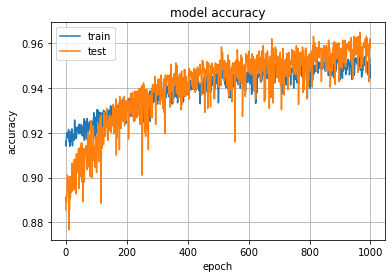

In [490]:
# summarize history for accuracy
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')

plt.title('model accuracy')
plt.ylabel('accuracy')

plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

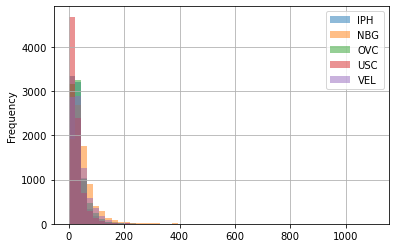

In [283]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame()
for i, el in spojeni_podaci_stanice_2018:
    id = stanice[i]['id']
    df[id] = el.PM10
ax = df.plot.hist(bins=50, alpha=0.5)
plt.grid()
plt.show()

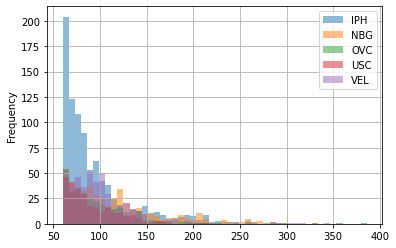

In [284]:
df = pd.DataFrame()
for i, el in spojeni_podaci_stanice_2018:
    id = stanice[i]['id']
    df[id] = el.PM10[el.PM10>60]
ax = df.plot.hist(bins=50, alpha=0.5)
plt.grid()
plt.show()

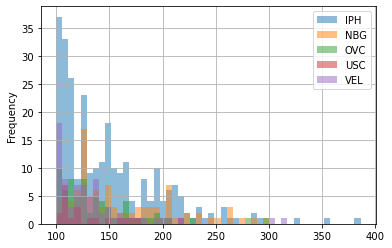

In [11]:
df = pd.DataFrame()
for i, el in spojeni_podaci_stanice_2018:
    id = stanice[i]['id']
    df[id] = el.PM10[el.PM10>100]
ax = df.plot.hist(bins=50, alpha=0.5)
plt.grid()
plt.show()

## Fuzzy normalizacija

In [12]:
def fuzzy_interval(val, a, b, c, d):
    if val<a: 
        return 0
    elif val<b:
        return (val-a)/(b-a)
    elif val<c:
        return 1
    elif val<d:
        return (d-val)/(d-c)
    else:
        return 0

In [13]:
x = np.arange(-20, 300, 1)
y0 = []
y1 = []
y2 = []
y3 = []
for xx in x:
    y0.append(fuzzy_interval(xx, -10,  10,  20, 30))
    y1.append(fuzzy_interval(xx,   10, 30, 70, 90))
    y2.append(fuzzy_interval(xx,  50, 70, 90, 110))
    y3.append(fuzzy_interval(xx,  80, 100, 500, 1000))
    

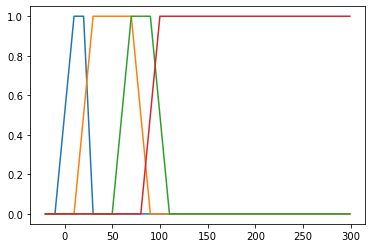

In [14]:
plt.plot(x, y0)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
